# 1K1K validation

In [1]:
import scanpy as sc
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import itertools
from pybedtools import BedTool
import statsmodels.formula.api as smf
import statsmodels.api as sm

import os
import pickle as pkl
%matplotlib inline
import qvalue

In [2]:
import sys
sys.path.append('/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.8-py3.8.egg')
sys.path.append('/home/ssm-user/Github/misc-seq/miscseq/')
import encode
import memento

In [3]:
data_path  = '/data_volume/memento/lupus/'

### Read SNP positions

In [4]:
pos = pd.read_csv(data_path + 'cm_cg.genos', sep='\t', index_col=0)

In [5]:
pos = pos[~pos.index.duplicated(keep='first')]

In [6]:
# pos = pos.drop_duplicates()

### Filter the anndata

### Get SNP-gene pairs using bedtools

### Read 1K1K eQTL output

In [15]:
gene_df = pd.read_csv('/home/ssm-user/Github/misc-seq/miscseq/GRCh38Genes.bed', sep='\t', header=None).iloc[:, [0, 1, 2, 5]]
gene_df.columns = ['chr', 'start', 'end', 'gene']

In [16]:
gene_df = gene_df.drop_duplicates('gene')[['gene', 'chr', 'start', 'end']]
gene_df.columns = ['geneid', 'chr', 's1', 's2']
gene_df.to_csv(data_path + 'geneloc.txt', index=False)
gene_df.columns = ['gene', 'chr', 's1', 's2']


In [17]:
onek1k_pos = pd.read_csv('1k1k_snps_chrpos.txt', header=None).iloc[:,0].tolist()
onek1k_info = pd.read_csv('1k1k_snp_info.txt', sep='\t', header=None).iloc[:,:3]
onek1k_info.columns = ['chr', 'pos', 'name']
onek1k_info['rsid'] = onek1k_info['chr'].astype(str) + ':' + onek1k_info['pos'].astype(str)

In [18]:
onek_replication = pd.read_csv(data_path + 'OneK1K_eqtls_for_replication.txt', sep='\t')#.query('cell_type == "Mono_C"')

In [19]:
onek_replication = onek_replication.merge(onek1k_info, left_on='SNP_rsID', right_on='name')#.query('cell_type == "Mono_C"')

In [20]:
onek_replication['gene'] = onek_replication['GeneID']
onek_replication['hit_id'] = onek_replication['gene'] + '*' + onek_replication['rsid']

In [21]:
onek_replication = onek_replication.query('rsid in @pos.index')

In [22]:
onek_replication = onek_replication.merge(gene_df.drop_duplicates('gene'), on='gene')
onek_replication['snp_location'] = onek_replication['rsid'].str.split(':').str[1].astype(int)
onek_replication['distance1'] = (onek_replication['s1'] - onek_replication['snp_location']).abs()
print('onek 100k window proportion', onek_replication.query('distance1 < 100000').shape[0]/onek_replication.shape[0])
onek_replication = onek_replication.query('distance1 < 100000')

onek 100k window proportion 0.21757941477854947


### Read mat eQTL output

### Run memento

In [60]:
gene_snp_pairs = pd.read_csv(data_path +'gene_snp_pairs_100k.csv').query('rsid in @pos.index').sample(frac=1)

In [62]:
adata = sc.read(data_path + 'Lupus_study_adjusted_counts_cM_filtered.h5ad')
adata = adata[adata.obs.ind_cov.isin(pos.columns)].copy()

adata.obs['capture_rate'] = 0.1
memento.setup_memento(adata, q_column='capture_rate', trim_percent=0.1, filter_mean_thresh=0.05)
memento.create_groups(adata, label_columns=['ind_cov'])

covariates = pd.read_csv(data_path + 'mateqtl_input/cm_cg.mateqtl_cov.txt', sep='\t', index_col=0).T
cov_df = covariates[['age', 'status','Female'] + [x for x in covariates.columns if '_g' in x]].loc[[x[3:] for x in adata.uns['memento']['groups']]]
donor_df = pos[[x[3:] for x in adata.uns['memento']['groups']]].T

In [63]:
block_size = 1000000

In [65]:
cov_df['const'] = 1
cov_df = cov_df[['const']]

In [66]:
for block in range(int(gene_snp_pairs.shape[0]/block_size)+1):
    
    gene_snp_pairs_block = gene_snp_pairs.iloc[   (block*block_size):((block+1)*block_size), :]
    
    memento.compute_1d_moments(adata, min_perc_group=.5, gene_list=gene_snp_pairs_block.gene.drop_duplicates().tolist())
    gene_to_snp = dict(gene_snp_pairs_block[gene_snp_pairs_block.gene.isin(adata.var.index)].groupby('gene').rsid.apply(list))

    memento.ht_1d_moments(
        adata, 
        covariate=cov_df,
        treatment=donor_df,
        treatment_for_gene=gene_to_snp,
        num_boot=5000, 
        verbose=1,
        num_cpus=30,
        resampling='bootstrap',
        approx=True,
        resample_rep=True)
    result = memento.get_1d_ht_result(adata).rename(columns={'tx':'rsid'})
    result.to_csv(data_path + 'window_100k/100k_result_approx_{}.csv'.format(block))

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done 140 tasks      | elapsed:   33.1s
[Parallel(n_jobs=30)]: Done 390 tasks      | elapsed:  1.3min
[Parallel(n_jobs=30)]: Done 740 tasks      | elapsed:  2.2min
[Parallel(n_jobs=30)]: Done 1190 tasks      | elapsed:  3.6min
[Parallel(n_jobs=30)]: Done 1740 tasks      | elapsed:  5.0min
[Parallel(n_jobs=30)]: Done 2390 tasks      | elapsed:  6.2min
[Parallel(n_jobs=30)]: Done 3140 tasks      | elapsed:  7.7min
[Parallel(n_jobs=30)]: Done 3402 out of 3402 | elapsed:  8.2min finished
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done 140 tasks      | elapsed

### Compare memento and mat eQTL outputs

In [7]:
result_list = []
for block in range(8):
    result_list.append(pd.read_csv(data_path + 'window_100k/100k_result_no_approx_{}.csv'.format(block)))
result = pd.concat(result_list)

In [41]:
result = pd.read_csv(data_path + 'window_100k/100k_result.csv', index_col=0)

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [42]:
result['fdr'] = memento.util._fdrcorrect(result['de_pval'])

In [43]:
result['hit_id'] = result['gene'] + '*' + result['rsid']
result['onek_valid'] = result['hit_id'].isin(onek_replication['hit_id'])

In [44]:
mateqtl_output = pd.read_csv(data_path + 'mateqtl_output/cm_cg_matqtl_cis.out', sep='\t')
mateqtl_output['hit_id'] = mateqtl_output['gene'] + '*' + mateqtl_output['SNP']
mateqtl_output['onek_valid'] = mateqtl_output['hit_id'].isin(onek_replication['hit_id'])
mateqtl_output['pvalue'] = mateqtl_output['p-value']

In [45]:
onek_replication.shape

(1911, 16)

In [46]:
result['qv'] = qvalue.estimate(result['de_pval'])

In [47]:
num_thresh = 100

memento_recall = np.zeros(num_thresh)
memento_precision = np.zeros(num_thresh)
mateqtl_recall = np.zeros(num_thresh)
mateqtl_precision = np.zeros(num_thresh)

memento_all_onek = result.onek_valid.sum()

for idx, threshold in enumerate(np.logspace(-7, -1.3, num_thresh)):
    
    memento_recall[idx] = result.query('qv < {}'.format(threshold)).onek_valid.sum()/memento_all_onek
    memento_precision[idx] = result.query('qv < {} & onek_valid'.format(threshold)).shape[0]/result.query('qv < {}'.format(threshold)).shape[0]

    mateqtl_recall[idx] = mateqtl_output.query('FDR < {}'.format(threshold)).onek_valid.sum()/onek_replication.shape[0]
    mateqtl_precision[idx] = mateqtl_output.query('FDR < {}'.format(threshold)).onek_valid.sum()/mateqtl_output.query('FDR < {}'.format(threshold)).shape[0]
    

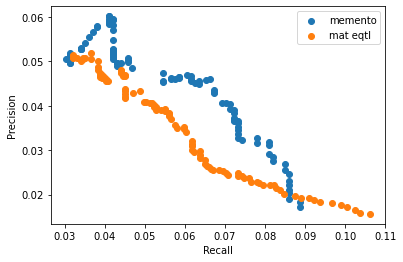

In [48]:
plt.scatter(memento_recall, memento_precision)
plt.scatter(mateqtl_recall, mateqtl_precision)
plt.ylabel('Precision');
plt.xlabel('Recall');
plt.legend(['memento', 'mat eqtl'])

In [49]:
result.head(2)

,gene,rsid,de_coef,de_se,de_pval,dv_coef,dv_se,dv_pval,fdr,hit_id,onek_valid,qv
0,NOC2L,1:940005,-0.012970,0.060849,0.914090,-0.038562,0.082969,0.725216,0.998980,NOC2L*1:940005,False,0.990554
1,NOC2L,1:936111,-0.008015,0.052235,0.943096,0.056780,0.076871,0.694598,0.999519,NOC2L*1:936111,False,0.991088


In [53]:
mateqtl_output['rsid'] = mateqtl_output['SNP']

In [54]:
merged = result.merge(mateqtl_output, on=['gene', 'rsid'])

In [55]:
merged.shape

(166288, 20)

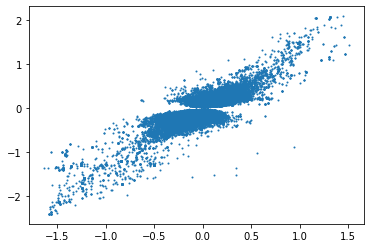

In [57]:
plt.scatter(merged['de_coef'], merged['beta'], s=1)
plt